In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import random
import time
import os
import math
import matplotlib
from tqdm import trange
from pylab import normal
import matplotlib.ticker as ticker

# TEN-ARMED Bandit Testbed

In [2]:
# seed_val = 1
# np.random.seed(seed_val)

In [3]:
class NArmedBandit:
    
    #10-armed bandit testbed with sample averages 
    def __init__(self,k=10,step_size = 0.1,eps = 0,UCB_c = None, sample_avg_flag = False,is_stationary = True,
                 init_estimates = 0.0,mu = 0, std_dev = 1):
        self.k = k
        self.step_size = step_size
        self.eps = eps
        self.init_estimates = init_estimates
        self.mu = mu
        self.std_dev = std_dev
        self.actions = np.zeros(k)
        self.true_reward = 0.0
        self.UCB_c = UCB_c
        self.sample_avg_flag = sample_avg_flag
        self.is_stationary = is_stationary
        self.re_init()
        
        
    def re_init(self):
        
        #true values of rewards for each action
        equal_true_val = 0.0
        self.actions = np.asarray([equal_true_val]*self.k)
        
        # estimation for each action
        self.Q_t = np.zeros(self.k) + self.init_estimates

        # num of chosen times for each action
        self.N_t = np.zeros(self.k)

        #best action chosen
        self.optim_action = np.argmax(self.actions)

        self.time_step = 0
        
    
    
    def changeArms(self,ch_mu = 0, ch_std = 0.01):
        #true value of rewards changes every step with increment taken from a distribution (mu=0,std = 0.01)
        #walk_step = normal(ch_mu,ch_std)
        for i in range(self.k):
            walk_step = normal(ch_mu,ch_std)
            self.actions[i] = self.actions[i] + walk_step
        
        #update best action chosen
        self.optim_action = np.argmax(self.actions)
        
        
    
    def act(self):
        val = np.random.rand()
        if val < self.eps:
            A_t = np.random.choice(np.arange(self.k))
            #print('action 1:',A_t)
        else:
            #max_estim = np.max(self.Q_t)
            #A_t = np.random.choice(np.where(self.Q_t == max_estim)[0])
            A_t = np.argmax(self.Q_t)
            #print('action 2:',A_t)
        return A_t
    
    
    
    def step(self,action):
        
        # generating the reward under N(real reward, 1)
        reward = np.random.randn() + self.actions[action]
        self.time_step += 1
        self.N_t[action] += 1
        

        # estimation with sample averages
        if self.sample_avg_flag == True:
            self.Q_t[action] += (reward - self.Q_t[action]) / self.N_t[action]
        else:
            # non-sationary with constant step size 
            self.Q_t[action] += self.step_size * (reward - self.Q_t[action])
            
        return reward
    
    
    def play(self,tasks,num_time_steps):
        rewards = np.zeros((tasks, num_time_steps))
        optim_action_counts = np.zeros(rewards.shape)
        for task in trange(tasks):
            self.re_init()
            for t in range(num_time_steps):
                action = self.act()
                reward = self.step(action)
                rewards[task, t] = reward
                if action == self.optim_action:
                    optim_action_counts[task, t] = 1
                if not self.is_stationary:
                    self.changeArms(ch_mu = 0, ch_std = 0.01)
        avg_optim_action_counts = optim_action_counts.mean(axis=0)*100
        avg_rewards = rewards.mean(axis=0)
        return avg_optim_action_counts, avg_rewards

In [4]:
def ex2_5(eps,tasks, num_time_steps, step_size = 0.1, is_stationary = True):
    const_step_results = {}
    keys = ['true','false']
    
    for key in keys: 
        const_step_results[key] = {}
        if key == 'true':
            print('running for sample_avg : ')
            bandit = NArmedBandit(k=10, step_size = step_size, eps = eps, sample_avg_flag = True, 
                                      is_stationary = is_stationary, init_estimates = 0.0,mu = 0, std_dev = 1)
        else: 
            print('running for constant step size : ')
            bandit = NArmedBandit(k=10, step_size = step_size, eps = eps, sample_avg_flag = False, 
                                  is_stationary = is_stationary, init_estimates = 0.0,mu = 0, std_dev = 1)
        
        avg_optim_action_counts,avg_rewards = bandit.play(tasks=tasks,num_time_steps = num_time_steps)
        const_step_results[key]['Optim_Action_Counts'] = avg_optim_action_counts
        const_step_results[key]['Average_Rewards'] = avg_rewards
        
    ##print(const_step_results['false']['Optim_Action_Counts'][const_step_results['false']['Optim_Action_Counts']!=0.0])

    for key in keys:
        if key == 'true':
            plt.plot(const_step_results[key]['Average_Rewards'],label = 'sample-average,' + r'$\epsilon = {:.02f}$'.format(eps))
        else:
            plt.plot(const_step_results[key]['Average_Rewards'],label = r'$\alpha = {:0.02f}, \epsilon = {:.02f}$'.format(step_size,eps))
    plt.xlabel('Steps')
    plt.ylabel('Average Rewards')
    plt.legend(loc="center left",frameon=True,bbox_to_anchor=(1,0.5))
    plt.title('Average Rewards - Sample Averages vs Constant Step-Size for Non-stationary')
    plt.show()
    
    fig, ax = plt.subplots()
    for key in keys:
        if key == 'true':
            ax.plot(const_step_results[key]['Optim_Action_Counts'],label = 'sample-average,' + r'$\epsilon = {:.02f}$'.format(eps))
        else:
            ax.plot(const_step_results[key]['Optim_Action_Counts'],label = r'$\alpha = {:0.02f}, \epsilon = {:.02f}$'.format(step_size,eps))
    ax.set_xlabel('Steps')
    ax.set_ylabel('% Optimal Action')
    ax.legend(loc="center left",frameon=True,bbox_to_anchor=(1,0.5))
    ax.yaxis.set_major_formatter(ticker.PercentFormatter())
    ax.set_title('% Optimal Action - Sample Averages vs Constant Step-Size for Non-stationary')
    plt.show()
    

  0%|          | 0/2000 [00:00<?, ?it/s]

starting 10 Armed Bandits play
running for sample_avg : 


  0%|          | 0/2000 [00:00<?, ?it/s]

running for constant step size : 


100%|██████████| 2000/2000 [07:36<00:00,  4.27it/s]


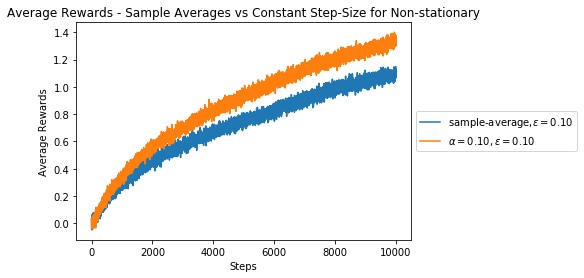

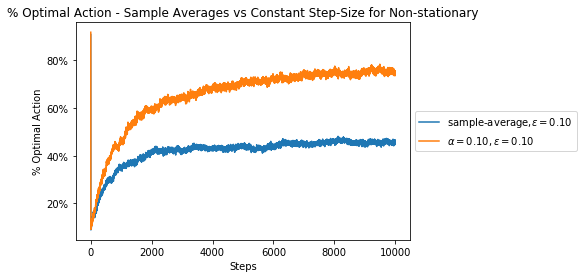

In [5]:
if __name__=='__main__':
    print('starting 10 Armed Bandits play')
    tasks = 2000#100#2#2000
    num_time_steps = 10000#10000#1000
    eps = 0.1
    ex2_5(eps,tasks, num_time_steps, step_size = 0.1, is_stationary = False)
    #playNArmedVBandit(epsilons,tasks, num_time_steps, step_size = 0.1, UCB_c = None, sample_avg_flag = True, 
    #                  init_estimates = 0.0, plot_avg_rew = False, plot_opt_cnt = True)
    #stationary 
    #fig_2_3(epsilons,tasks, num_time_steps, step_szie = 0.1)
    #non-stationary
    #fig_2_3(epsilons,tasks, num_time_steps, step_szie = 0.1,is_stationary = False)